In [54]:
# IMPORT LIBRARIES
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import functions
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.image as mpimg

In [55]:
# IMPORT SESSION DATA FROM "Portfolio" DATASET WHICH IS BROKEN DOWN BY SESSION
df_sessions = pd.read_csv('data/SB-County-County-Public-Portfolio-stations-report-01_01_20-12_31_24.csv', low_memory=False)
# print(df_sessions.head())
print(f"The dataframe has {df_sessions.shape[0]} and {df_sessions.shape[1]} columns")

The dataframe has 88919 and 30 columns


## Data Preparation

### Santa Barbara County "Portfolio" Data That Describes Individual E.V. Charging Sessions

In [56]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88919 entries, 0 to 88918
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   10-digit session UID         88919 non-null  int64  
 1   Session ID                   88919 non-null  object 
 2   Session start                88919 non-null  object 
 3   Session end                  88919 non-null  object 
 4   Session duration (minutes)   88758 non-null  float64
 5   Charging duration (minutes)  88919 non-null  float64
 6   Session idle (minutes)       88758 non-null  float64
 7   Estimated Completion Time    88919 non-null  object 
 8   kWh delivered                84516 non-null  float64
 9   MAX kW                       88439 non-null  float64
 10  AVG kW                       88439 non-null  float64
 11  SoC Start                    6134 non-null   object 
 12  SoC End                      16264 non-null  object 
 13  User            

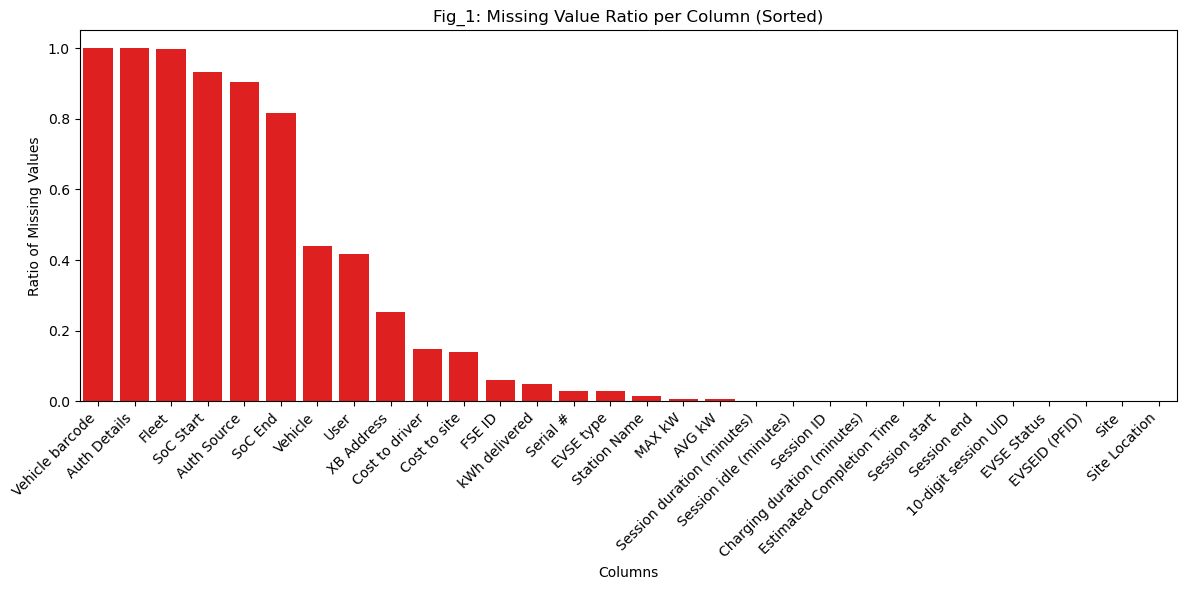

In [57]:
# Gets the mean of missing values in each column. Since True = 1 and False = 0 the mean tells us how much of the data is missing.
df_sessions_w_missing_values = df_sessions.isnull().mean().sort_values(ascending=False)

# Create the bar plot with Seaborn
plt.figure(figsize=(12, 6))
fig1 = sns.barplot(x=df_sessions_w_missing_values.index, y=df_sessions_w_missing_values.values, color='red')

# Customize the plot
plt.xlabel('Columns')
plt.ylabel('Ratio of Missing Values')
plt.title('Fig_1: Missing Value Ratio per Column (Sorted)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot
plt.savefig('images/sessions/Fig_1.jpg')

# Show the plot
plt.show()


### Missing Values Analysis
The features 'Auth Source', 'Vehicle barcode', 'Auth Details', 'Fleet', 'SoC Start', 'SoC End', and 'XB Address' have over 40% missing values and will thus be removed from the dataframe. Additionally, the 'Session ID' feature is an identifier that won't likely help with our analysis and prediction efforts, so it is also to be removed. Similarly, the '10-digit session UID' is unlikely to be useful for statistical analysis and will also be removiki/One-hot). 

In [58]:
# Drop columns from the DataFrame
df_sessions = df_sessions.drop(['10-digit session UID', 'Auth Source', 'Vehicle barcode', 'Auth Details', 'Fleet', 'SoC Start', 
                               'SoC End', 'XB Address', 'Session ID'], axis=1)



### Imputation
Due to their potential value for our statistical and decision tree analysis, we will however impute missing values with "unknown" for the 'Vehicle' and 'User' features despite the large amount of missing values. It could be useful to see if there is a vehicle or group of drivers that reveal any patterns. All data is of course anonymous. Similarly, the 'FSE ID', 'Serial #', 'EVSE type', and 'Station Name' values will be imputed with "unknown". All these categorical features will be one-hot encoded.

The 'Cost to ,er' and 'Cost t, 'MAX kW', 'AVG kW'o site' features will be imputed with averages, at least to start. Potentially an arithmetic equation or prediction alg(Linear Regressionss) orithm could be leveraged to produce the missing vki/One-hot). 

In [59]:
# Replace NaN values with "unknown" for categorical features
cat_features_w_missing = ['Vehicle', 'User', 'FSE ID', 'Serial #', 'EVSE type', 'Station Name']
df_sessions[cat_features_w_missing] = df_sessions[cat_features_w_missing].fillna("unknown")

# Replace NaN values with the mean value for the respective features
num_features_w_missing = ['Cost to driver', 'Cost to site', 'MAX kW', 'AVG kW', 'Session duration (minutes)', 'Session idle (minutes)', 'kWh delivered' ]
df_sessions[num_features_w_missing] = df_sessions[num_features_w_missing].fillna(df_sessions[num_features_w_missing].mean())

es.

### Feature Engineering
The 'SoC Start' and 'SoC End' features have very low reported values (about 10% or less); we could however, in a future iteration, estimate these values with an equation as well. Jerel Francisco deemed these to be important metrics because they give us insight into the nature of the passengers' charging activity. Was the vehicle fully depleted when they started charging? Did they fully charge the vehicle or did they just "top it off"? For now, we'll refrain from these experimentations, but it could be an avenue for further fine-tuning. In essence, it would be an effort in feature engineering with the 10% of existing values helping corroborate the calc

For the decision tree evaluation we will create a feature '4_plus_hour_session' when 'Session duration (minutes)' > 240 minutesulation.

### One-Hot Encoding
As described above, the categorical features that remain in the dataframe will be [one-hot encoded](https://en.wikipedia.org.iki/One-hot). 

### Filtering out SB County Fleet Data to Focus on Public Usage

Based on the following spreadsheet provided by the S.B. County's 
Zero-Emission Vehicles and Mobility Planni Jerel Francisco our analysis is to focus on the public usage of the charging stations. 

: https://docs.google.com/spreadsheets/d/1xRGK_ZnoM93P0HDJcok5WfZFDcxvYETne-_3y1qC_dE/edit?pli=1&gid=0#gid=0r Road"
]0 Foster Road

In [60]:
# All Delta (type 3) Sites
df_sessions_delta = df_sessions.query("`EVSE type` == 'Delta DCFC 100kW'")

sites_to_include_for_webasto = [
    "SBAPCD",
    "SB CARP Lookout Park",
    "SB CARP South Via Real",
    "SB IV Embarcadero",
    "SB Jail",
    "SM PW 620 Foster Road"
]

# Apply both filters using query
df_sessions_webasto = df_sessions.query("Site in @sites_to_include_for_webasto and `EVSE type` == 'Webasto DX'")

# Concatenate the two dataframes
df_sessions = pd.concat([df_sessions_delta, df_sessions_webasto])

# Display site counts in the combined dataframe
df_sessions['Site'].value_counts()

SB Admin                  10238
SB Health Services         9684
SB Jail                    3674
SB CARP South Via Real     2791
SB IV Embarcadero          2523
SB CARP Lookout Park       1791
Name: Site, dtype: int64

In [61]:
df_sessions['EVSE type'].value_counts()

Delta DCFC 100kW    19922
Webasto DX          10779
Name: EVSE type, dtype: int64

## Statistical Analysis of the Sessions Data

In [62]:
# Basic Statistical Analysis
df_sessions.describe()

,Session duration (minutes),Charging duration (minutes),Session idle (minutes),kWh delivered,MAX kW,AVG kW,Cost to site,Cost to driver
count,30701.000000,30701.000000,30701.000000,30701.000000,30701.000000,30701.000000,30701.000000,30701.00000
mean,109.959493,51.697623,58.005248,14.667198,21.225176,14.387435,6.480154,2.90626
std,1224.768305,73.995389,1223.537770,16.939677,28.026509,19.870947,9.422527,6.41301
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,3.530000,0.000000,1.100000,0.000000,0.000000,0.000000,0.370000,0.25500
50%,38.130000,26.750000,1.900000,11.076000,3.934000,3.219000,2.840000,2.70020
75%,95.650000,67.970000,6.730000,22.689000,50.130000,27.930000,7.835000,3.35100
max,117681.100000,786.500000,117681.100000,119.160000,517.170000,98.995000,634.279000,634.27900


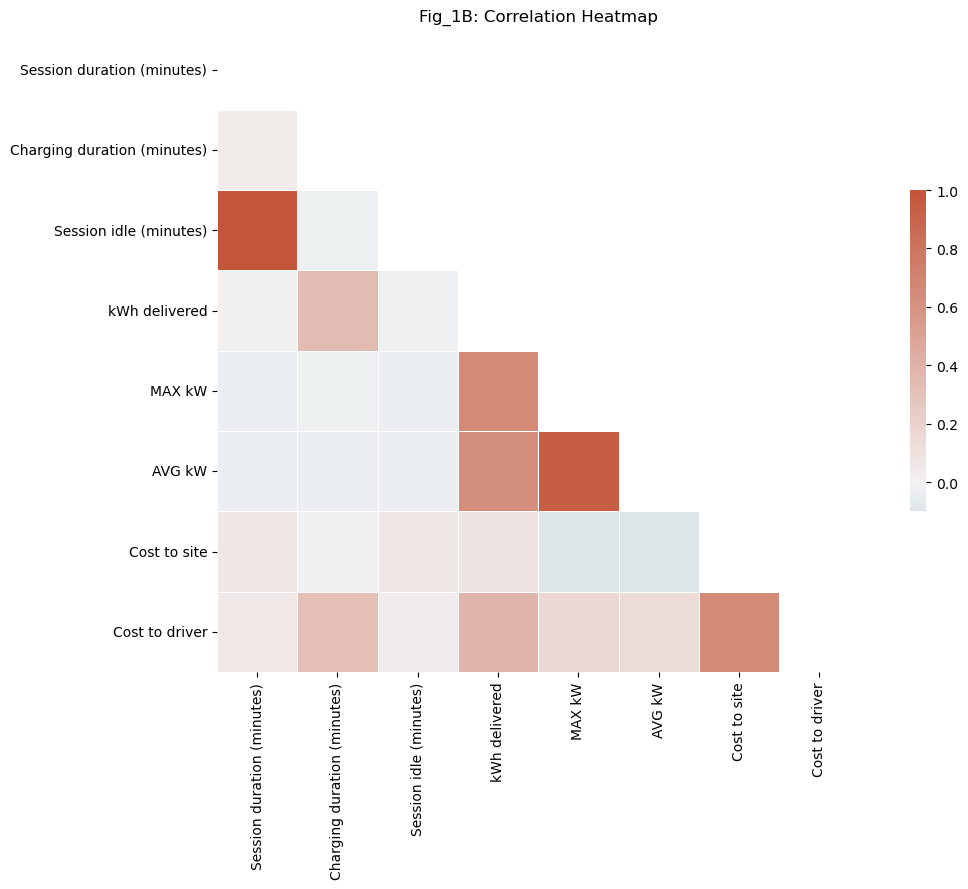

In [63]:
# Get correlations between the features 
df_sessions_corr = df_sessions.corr()
# print(df_sessions_corr)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_sessions_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_sessions_corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Fig_1B: Correlation Heatmap')

# Adjust layout to prevent labels from being cropped off
plt.tight_layout()

# Save plot
plt.savefig('images/fig1B.jpg')

# Show the plot
plt.show()

In [64]:
# Top Correlations

# NOTE: I don't think this is useful as is but might be helpful if we want to filter down to some more useful correlations.

# Convert correlation matrix to a series for easier manipulation
corr_pairs = df_sessions_corr.unstack()

# Remove self-correlations (which are always 1)
corr_pairs = corr_pairs[corr_pairs < 1]

# Get absolute values for sorting (to include negative correlations)
corr_pairs_abs = corr_pairs.abs().sort_values(ascending=False)

# Get top 5 correlations (these will be the strongest positive and negative)
top_5_correlations = corr_pairs_abs.head(5)

# Display the results with their actual correlation values (not absolute)
for idx, (pair, _) in enumerate(top_5_correlations.items(), 1):
    feature1, feature2 = pair
    correlation = corr_pairs[pair]
    print(f"{idx}. {feature1} — {feature2}: {correlation:.4f}")

1. Session duration (minutes) — Session idle (minutes): 0.9982
2. Session idle (minutes) — Session duration (minutes): 0.9982
3. MAX kW — AVG kW: 0.9398
4. AVG kW — MAX kW: 0.9398
5. Cost to driver — Cost to site: 0.6617


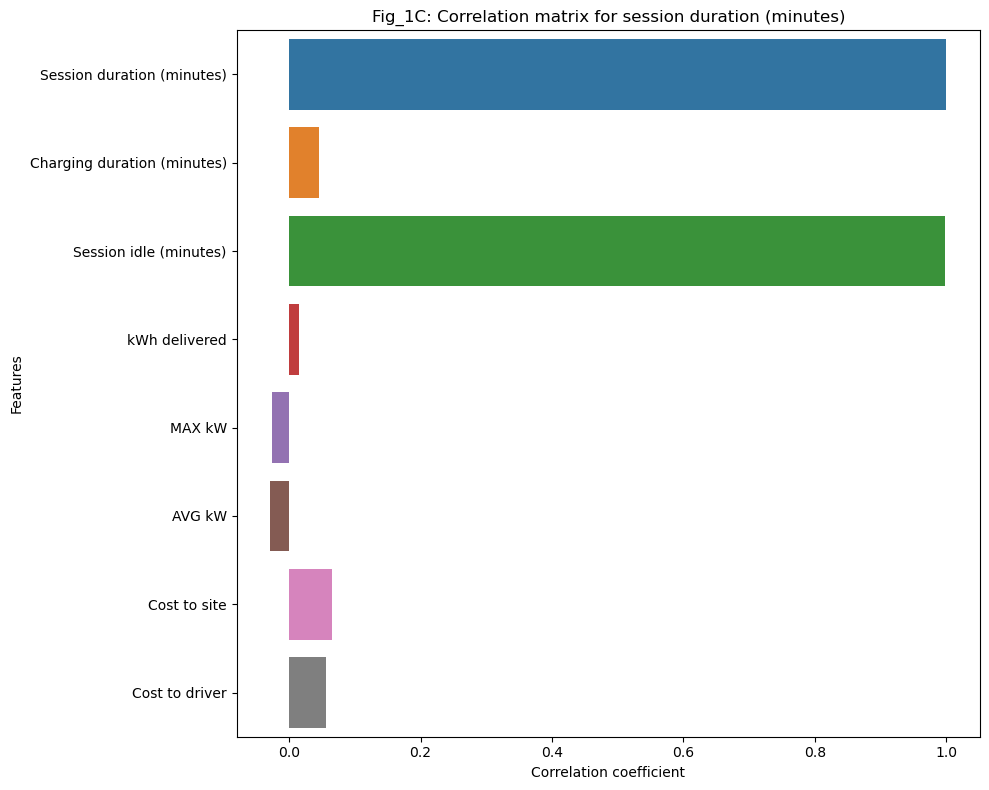

In [65]:
# Fig_1C: Correlation matrix for session duration (minutes)

# Get correlations between the features 
df_sessions_corr = df_sessions.corr()

# Get correlation matrix for AVG session duration (minutes)
df_sessions_corr_avg_sessions = df_sessions_corr['Session duration (minutes)']

# Seaborn plot for correlations
plt.figure(figsize=(10, 8))
sns.barplot(x=df_sessions_corr_avg_sessions.values, y=df_sessions_corr_avg_sessions.index)
plt.title('Fig_1C: Correlation matrix for session duration (minutes)')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')

# Adjust layout to prevent labels from being cropped off
plt.tight_layout()

# Save plot
plt.savefig('images/sessions/Fig1_C.jpg')

# Show the plot
plt.show()

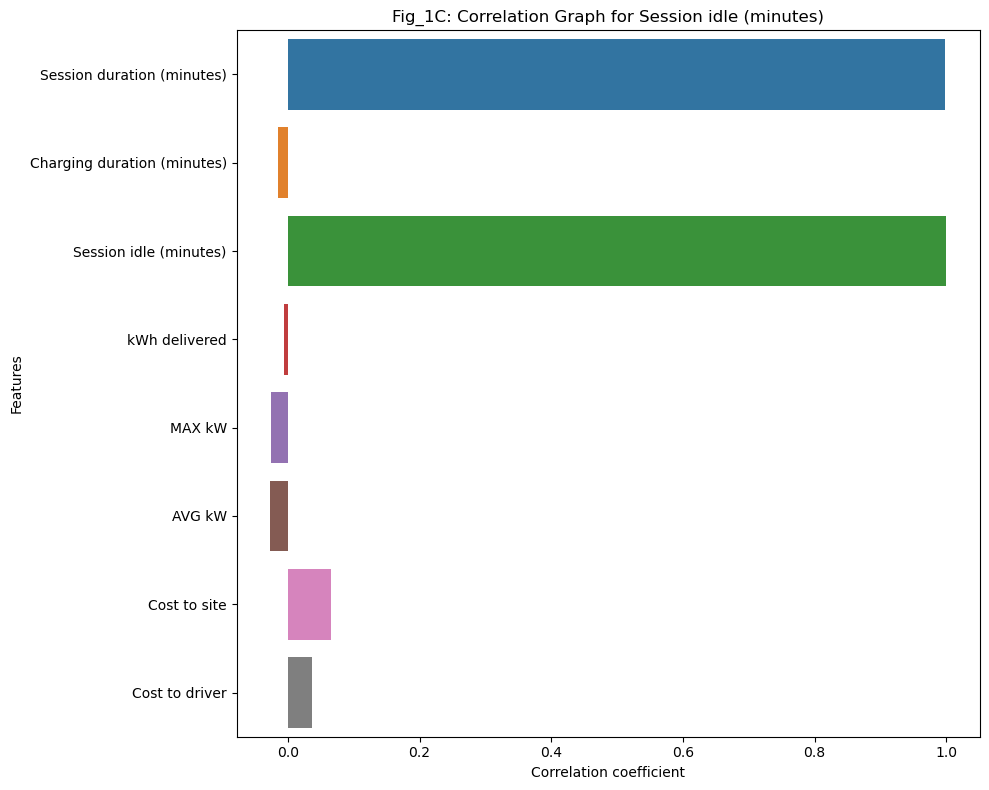

In [66]:
# Fig_1C: Correlation matrix for AVG session duration (minutes)

# Get correlations between the features 
df_sessions_corr = df_sessions.corr()

# Get correlation matrix for AVG session duration (minutes)
df_sessions_corr_avg_sessions = df_sessions_corr['Session idle (minutes)']

# Seaborn plot for correlations
plt.figure(figsize=(10, 8))
sns.barplot(x=df_sessions_corr_avg_sessions.values, y=df_sessions_corr_avg_sessions.index)
plt.title('Fig_1C: Correlation Graph for Session idle (minutes)')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')

# Adjust layout to prevent labels from being cropped off
plt.tight_layout()

# Save plot
plt.savefig('images/sessions/Fig_1C.jpg')

# Show the plot
plt.show()

## Energy Delivered (kWh) vs Completed Sessions - Explore SB County Question 

### Analysing Sessions Data Set
report: https://colab.research.google.com/drive/1NAge1_GYw95EISVNFlWXOUP2JGTZAvxp#scrollTo=xRVDbcpiPBHQ

In [67]:
# Filtering out sessions that had no charging
df_sessions_session_completed = df_sessions[df_sessions['kWh delivered'] > 0.01]

print(f"Completed Sessions: {df_sessions_session_completed.shape[0]}")
print(f"All Sessions: {df_sessions.shape[0]}")
print(f"Non-completed Sessions: {df_sessions.shape[0] - df_sessions_session_completed.shape[0]}")

# Calculate completion percentage
completion_rate = (df_sessions_session_completed.shape[0] / df_sessions.shape[0]) * 100
print(f"Completion Rate: {completion_rate:.2f}%")

Completed Sessions: 21997
All Sessions: 30701
Non-completed Sessions: 8704
Completion Rate: 71.65%


In [68]:
# Calculate percentage of completed vs. non-completed sessions
completed_sessions = df_sessions_session_completed.shape[0]
all_sessions = df_sessions.shape[0]
non_completed_sessions = all_sessions - completed_sessions
completion_rate = (completed_sessions / all_sessions) * 100

print(f"Completed Sessions: {completed_sessions} ({completion_rate:.2f}%)")
print(f"Non-completed Sessions: {non_completed_sessions} ({100-completion_rate:.2f}%)")

# First, create your filtered DataFrame using a clear copy
zero_energy_sessions = df_sessions[df_sessions['kWh delivered'] <= 0.01].copy()

# Check for patterns in non-completed sessions
# Duration statistics
if 'Session duration (minutes)' in zero_energy_sessions.columns:
    print(f"\nNon-completed session duration statistics:")
    print(zero_energy_sessions['Session duration (minutes)'].describe())

# Vehicle type breakdown
if 'Vehicle' in zero_energy_sessions.columns:
    print(f"\nVehicle types in non-completed sessions:")
    print(zero_energy_sessions['Vehicle'].value_counts().head())

# Status breakdown
if 'EVSE Status' in zero_energy_sessions.columns:
    print(f"\nEVSE status in non-completed sessions:")
    print(zero_energy_sessions['EVSE Status'].value_counts())

# Time of day analysis
if 'Session start' in zero_energy_sessions.columns:
    zero_energy_sessions['Hour'] = pd.to_datetime(zero_energy_sessions['Session start']).dt.hour
    print(f"\nHourly distribution of non-completed sessions:")
    print(zero_energy_sessions['Hour'].value_counts().sort_index())


Completed Sessions: 21997 (71.65%)
Non-completed Sessions: 8704 (28.35%)

Non-completed session duration statistics:
count     8704.000000
mean        38.172653
std        318.558350
min          0.000000
25%          0.850000
50%          1.900000
75%          6.030000
max      21538.920000
Name: Session duration (minutes), dtype: float64

Vehicle types in non-completed sessions:
unknown    3836
42191.0     416
43954.0     334
39838.0     192
45750.0     176
Name: Vehicle, dtype: int64

EVSE status in non-completed sessions:
FINISHED    8704
Name: EVSE Status, dtype: int64

Hourly distribution of non-completed sessions:
0      88
1      94
2      97
3      79
4     108
5     114
6     182
7     276
8     508
9     544
10    636
11    669
12    667
13    721
14    667
15    566
16    562
17    534
18    426
19    340
20    271
21    244
22    213
23     98
Name: Hour, dtype: int64


In [69]:
# Create filtered DataFrame for completed sessions
completed_energy_sessions = df_sessions[df_sessions['kWh delivered'] > 0.01].copy()

# Duration statistics
if 'Session duration (minutes)' in completed_energy_sessions.columns:
    print(f"\nCompleted session duration statistics:")
    print(completed_energy_sessions['Session duration (minutes)'].describe())

# Vehicle type breakdown
if 'Vehicle' in completed_energy_sessions.columns:
    print(f"\nVehicle types in completed sessions:")
    print(completed_energy_sessions['Vehicle'].value_counts().head())

# Status breakdown
if 'EVSE Status' in completed_energy_sessions.columns:
    print(f"\nEVSE status in completed sessions:")
    print(completed_energy_sessions['EVSE Status'].value_counts())

# Time of day analysis
if 'Session start' in completed_energy_sessions.columns:
    completed_energy_sessions['Hour'] = pd.to_datetime(completed_energy_sessions['Session start']).dt.hour
    print(f"\nHourly distribution of completed sessions:")
    print(completed_energy_sessions['Hour'].value_counts().sort_index())

# Additional insights for completed sessions
if 'kWh delivered' in completed_energy_sessions.columns:
    print(f"\nEnergy delivery statistics (kWh):")
    print(completed_energy_sessions['kWh delivered'].describe())

# Analyze charging efficiency
if all(col in completed_energy_sessions.columns for col in ['Charging duration (minutes)', 'kWh delivered']):
    completed_energy_sessions['kWh per minute'] = completed_energy_sessions['kWh delivered'] / completed_energy_sessions['Charging duration (minutes)']
    print(f"\nCharging efficiency statistics (kWh per minute):")
    print(completed_energy_sessions['kWh per minute'].describe())



Completed session duration statistics:
count     21997.000000
mean        138.364851
std        1432.007269
min           0.000000
25%          26.650000
50%          56.400000
75%         132.100000
max      117681.100000
Name: Session duration (minutes), dtype: float64

Vehicle types in completed sessions:
unknown    2948
42191.0    1367
43954.0    1138
39190.0     996
45750.0     670
Name: Vehicle, dtype: int64

EVSE status in completed sessions:
FINISHED    21997
Name: EVSE Status, dtype: int64

Hourly distribution of completed sessions:
0      201
1      219
2      306
3      251
4      293
5      430
6      977
7      903
8     1510
9     1411
10    1769
11    1696
12    1793
13    1676
14    1458
15    1265
16    1199
17    1250
18     832
19     757
20     642
21     493
22     366
23     300
Name: Hour, dtype: int64

Energy delivery statistics (kWh):
count    21997.000000
mean        20.470807
std         16.783716
min          0.011000
25%          8.824000
50%         14.18

In [70]:
# Compare idle time between completed and non-completed sessions
if 'Session idle (minutes)' in df_sessions.columns:
    print("\nIdle time comparison:")
    print(f"Average idle time for completed sessions: {completed_energy_sessions['Session idle (minutes)'].mean():.2f} minutes")
    print(f"Average idle time for non-completed sessions: {zero_energy_sessions['Session idle (minutes)'].mean():.2f} minutes")

# Compare by location
if 'Site Location' in df_sessions.columns:
    completed_location_counts = completed_energy_sessions['Site Location'].value_counts()
    non_completed_location_counts = zero_energy_sessions['Site Location'].value_counts()
    
    total_by_location = df_sessions['Site Location'].value_counts()
    
    # Calculate completion rate by location
    print("\nTop locations by completion rate:")
    for location in total_by_location.index[:5]:
        completed = completed_location_counts.get(location, 0)
        total = total_by_location.get(location)
        rate = (completed / total) * 100 if total > 0 else 0
        print(f"{location}: {rate:.2f}% completion rate ({completed}/{total})")


Idle time comparison:
Average idle time for completed sessions: 66.58 minutes
Average idle time for non-completed sessions: 36.35 minutes

Top locations by completion rate:
105 E. Anapamu St, Santa Barbara, CA 93101: 64.40% completion rate (6593/10238)
315 Camino del Remedio, Santa Barbara, CA  93110: 71.16% completion rate (6891/9684)
4430 Calle Real, Santa Barbara, CA 93110: 88.32% completion rate (3245/3674)
6728 Via Real, Carpinteria, CA 93013: 76.10% completion rate (2124/2791)
881 Embarcadero del Mar, Isla Vista, CA 93117: 77.13% completion rate (1946/2523)


### Context: County has a 4 hour charging policy. 
Price increases per minute to stay plugged in 
#### 
Hypothesis: Average Session duration should be around 4 hours
Average Charging duration should be much lower than 4 hours 


Number of public charging sessions that are 4 hours or longer: 1920 (6.25%)
Number of public charging sessions: 30701


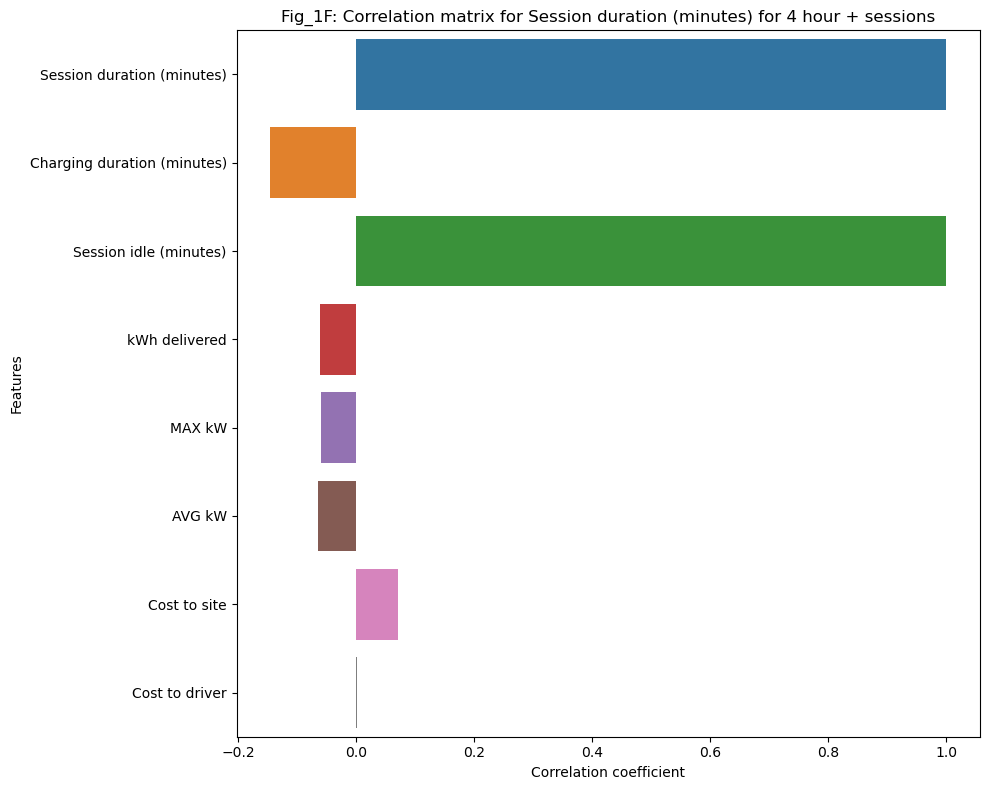

In [71]:
# Fig_1F: Correlation matrix for sessions longer than 4 hours (180 minutes)
# Get long sessions
long_sessions = df_sessions[df_sessions['Session duration (minutes)'] > 240]
long_sessions_percentage = round((long_sessions.shape[0]/df_sessions.shape[0])*100, 2)
print(f"Number of public charging sessions that are 4 hours or longer: {long_sessions.shape[0]} ({long_sessions_percentage}%)")
print(f"Number of public charging sessions: {df_sessions.shape[0]}")
# Get correlations between the features 
long_sessions_corr = long_sessions.corr()

# Get correlation matrix for AVG session duration (minutes)
long_sessions_corr_mtx = long_sessions_corr['Session duration (minutes)']

# Seaborn plot for correlations
plt.figure(figsize=(10, 8))
sns.barplot(x=long_sessions_corr_mtx.values, y=long_sessions_corr_mtx.index)
plt.title('Fig_1F: Correlation matrix for Session duration (minutes) for 4 hour + sessions')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')

# Adjust layout to prevent labels from being cropped off
plt.tight_layout()

# Save plot
plt.savefig('images/plots/fig1F.jpg')

# Show the plot
plt.show()

# 

In [72]:
df_sessions['EVSE type'].value_counts()

Delta DCFC 100kW    19922
Webasto DX          10779
Name: EVSE type, dtype: int64

### When EVSE Type is Webasto and from Public Sites - Average Session Duration (total time EV Plugged into station) vs Average Charging Duration (total time EV: receiving electrons) ?

How long are the charging sessions? - By Level 2 vs Level 3 (Column name: EVSE Type)?
 
How long are the session durations? By Level 2 vs Level?
 3
How long is the charging duration ? by Level 2 vs Leve?
l 3
Level 2: Webasto 
Level 3: Delta 


In [73]:
# Filter by Level 2 charging method and Describe statistics
df_sessions_lvl2 = df_sessions[df_sessions['EVSE type'] == 'Webasto DX'].copy()
stats_df_webasto = df_sessions_lvl2.describe()
stats_df_webasto.to_csv('webasto_dx_statistics.csv')
stats_df_webasto

,Session duration (minutes),Charging duration (minutes),Session idle (minutes),kWh delivered,MAX kW,AVG kW,Cost to site,Cost to driver
count,10779.000000,10779.000000,10779.000000,10779.000000,10779.000000,10779.000000,10779.000000,10779.000000
mean,138.511628,98.945139,39.280991,8.503271,3.920709,3.116377,5.100143,2.737848
std,172.873307,101.871647,140.225916,9.247115,2.904308,2.695593,9.249368,7.078003
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.700000,0.630000,0.670000,0.113000,1.626500,0.076000,0.334500,0.322000
50%,109.550000,73.750000,1.770000,6.388000,3.400000,2.897000,1.541000,1.536000
75%,213.385000,177.265000,29.940000,11.898000,6.630000,5.813500,3.877000,2.700200
max,6936.880000,786.500000,6936.880000,72.295000,8.434000,8.119000,285.112000,285.112000


In [74]:
# Filter by Level 3 charging method and Describe statistics
df_sessions_lvl3 = df_sessions[df_sessions['EVSE type'] == 'Delta DCFC 100kW'].copy()
stats_df_delta = df_sessions_lvl3.describe()
stats_df_delta.to_csv('delta_statistics.csv')
stats_df_delta

,Session duration (minutes),Charging duration (minutes),Session idle (minutes),kWh delivered,MAX kW,AVG kW,Cost to site,Cost to driver
count,19922.000000,19922.000000,19922.000000,19922.000000,19922.000000,19922.000000,19922.000000,19922.000000
mean,94.511071,26.133876,68.136197,18.002254,30.587934,20.485755,7.226823,2.997381
std,1514.883044,31.011738,1515.303799,19.085970,30.923233,22.330353,9.431318,6.020900
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.350000,0.000000,1.330000,0.000000,0.000000,0.000000,0.473000,0.073250
50%,25.370000,16.435000,1.900000,11.409536,32.725000,16.441000,4.099500,2.700200
75%,54.627500,45.000000,3.430000,30.977500,53.770000,37.761000,9.651500,4.159500
max,117681.100000,347.880000,117681.100000,119.160000,517.170000,98.995000,634.279000,634.279000


## Decision Tree Model

In [75]:
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

### Target Variable 

In [88]:
# Create a new binary feature for sessions longer than 4 hours
df_sessions['4_plus_hour_session'] = df_sessions['Session duration (minutes)'] > 240

### Split Data into Training and Testing Sets

In [89]:
# train_test_split?

In [90]:
X = df_sessions.drop('4_plus_hour_session', axis=1)
y = df_sessions['4_plus_hour_session']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

### Setup Preprocessing

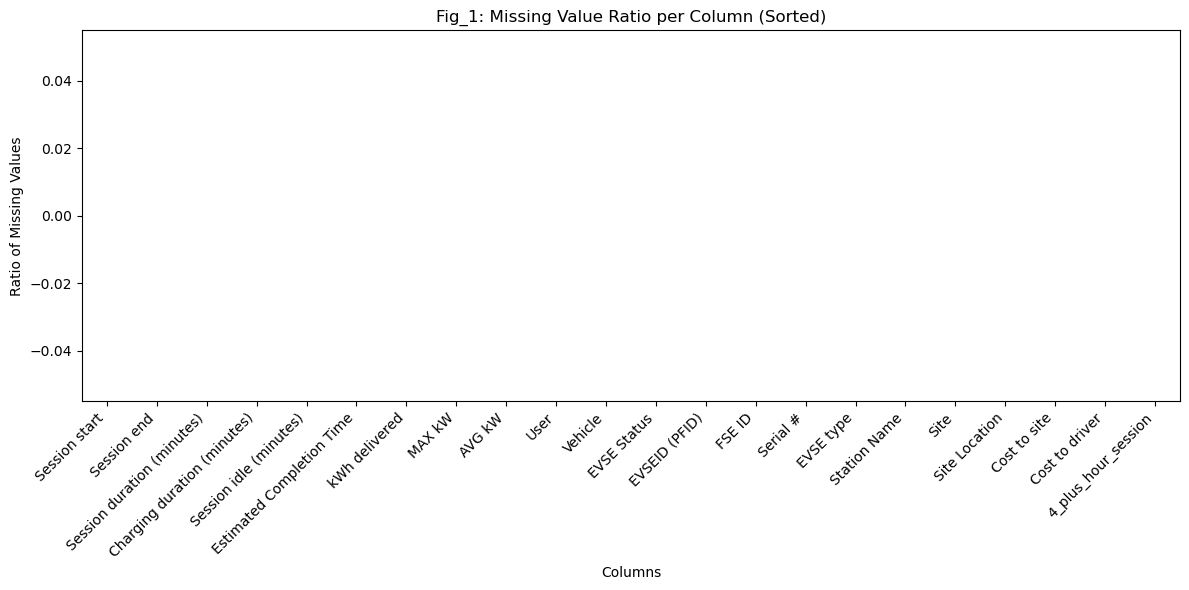

In [91]:
# Gets the mean of missing values in each column. Since True = 1 and False = 0 the mean tells us how much of the data is missing.
df_sessions_w_missing_values = df_sessions.isnull().mean().sort_values(ascending=False)

# Create the bar plot with Seaborn
plt.figure(figsize=(12, 6))
fig1 = sns.barplot(x=df_sessions_w_missing_values.index, y=df_sessions_w_missing_values.values, color='red')

# Customize the plot
plt.xlabel('Columns')
plt.ylabel('Ratio of Missing Values')
plt.title('Fig_1: Missing Value Ratio per Column (Sorted)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot
plt.savefig('images/sessions/Fig_1.jpg')

# Show the plot
plt.show()

In [92]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30701 entries, 0 to 85768
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Session start                30701 non-null  object 
 1   Session end                  30701 non-null  object 
 2   Session duration (minutes)   30701 non-null  float64
 3   Charging duration (minutes)  30701 non-null  float64
 4   Session idle (minutes)       30701 non-null  float64
 5   Estimated Completion Time    30701 non-null  object 
 6   kWh delivered                30701 non-null  float64
 7   MAX kW                       30701 non-null  float64
 8   AVG kW                       30701 non-null  float64
 9   User                         30701 non-null  object 
 10  Vehicle                      30701 non-null  object 
 11  EVSE Status                  30701 non-null  object 
 12  EVSEID (PFID)                30701 non-null  object 
 13  FSE ID          

In [109]:
# This function selects the object / categorical features for one-hot encoding
selector = make_column_selector(dtype_include=object)

In [132]:
# Clean Up Problematic Features
# Define columns to remove
columns_to_remove = ['Session start', 'Session end', 'Estimated Completion Time', 'User', 'Vehicle', 'Session duration (minutes)', 'Session idle (minutes)', 'Charging duration (minutes)']

# Remove these columns from your data
X_train = X_train.drop(columns_to_remove, axis=1, errors='ignore')
X_test = X_test.drop(columns_to_remove, axis=1, errors='ignore')

# Make sure all categorical features are strings
for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

In [133]:
transformer = make_column_transformer(
    (OneHotEncoder(drop = 'first'), selector),
    remainder = StandardScaler()
)

In [134]:
# DecisionTreeClassifier?

In [140]:
# Create pipeline with DecisionTreeClassifier
dtree_pipe = Pipeline([
    ('transformer', transformer),
    ('dtree', DecisionTreeClassifier(
        max_depth=3,
        # min_samples_split=2,  # Lower this value
        # min_samples_leaf=1,   # Lower this value 
        random_state=42))
])

# Fit the model
dtree_pipe.fit(X_train, y_train)

# Evaluate
pipe_acc = dtree_pipe.score(X_test, y_test)
print(f"Decision Tree Accuracy: {pipe_acc}")

Decision Tree Accuracy: 0.9588432688511647


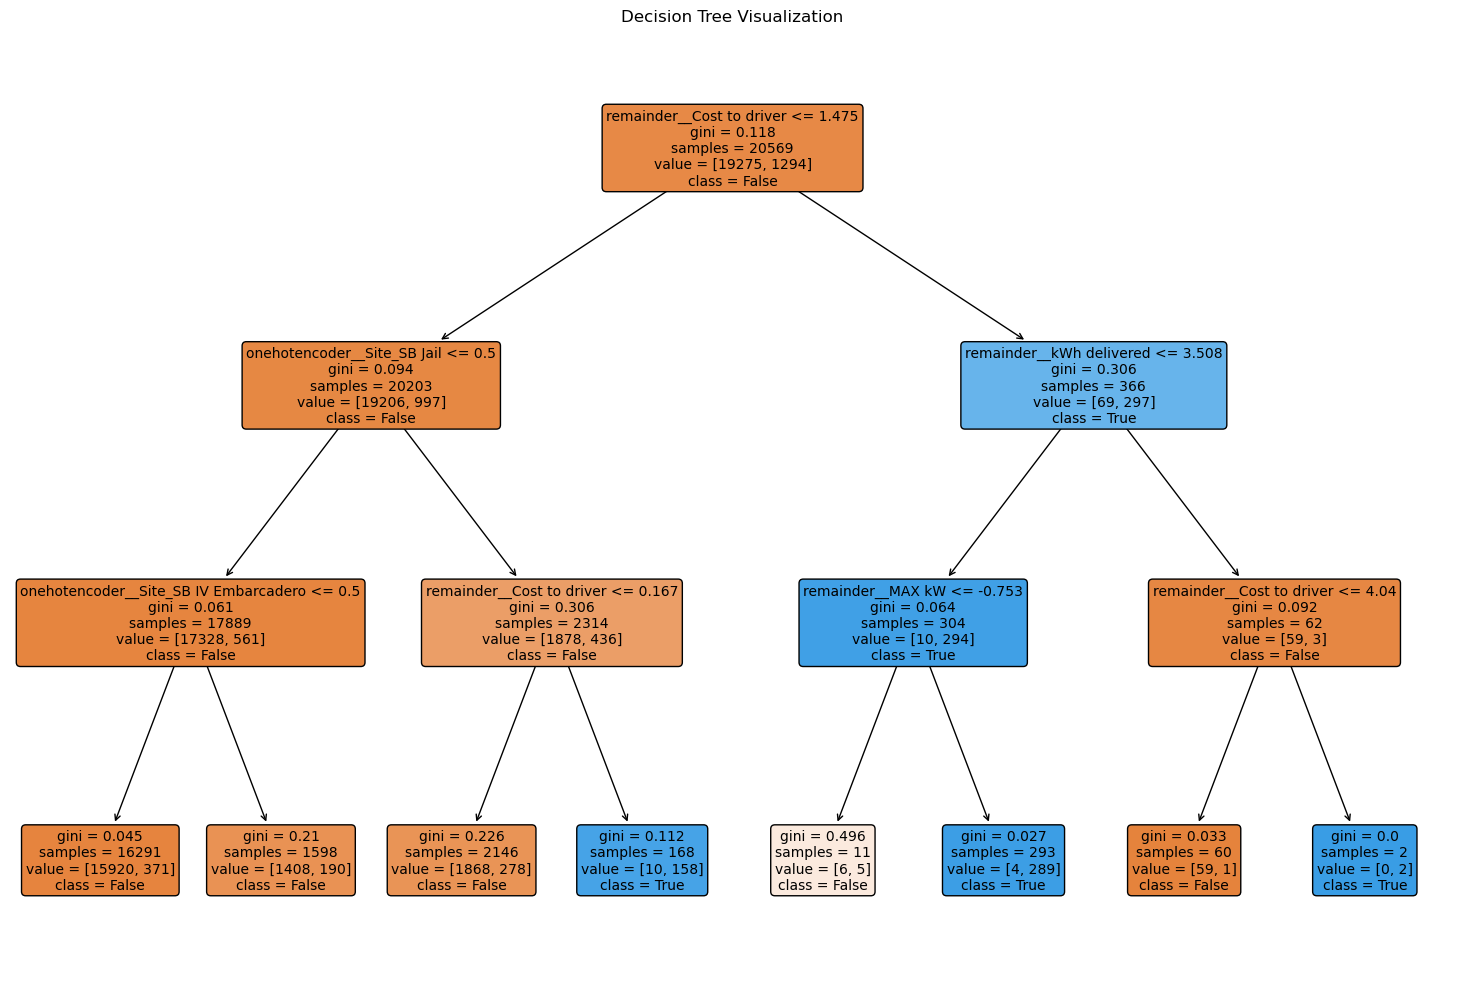

In [141]:
# Access the decision tree classifier from the pipeline
decision_tree = dtree_pipe.named_steps['dtree']

# Create a figure with a suitable size
plt.figure(figsize=(15, 10))

# Plot the tree
plot_tree(decision_tree, 
          filled=True, 
          feature_names=transformer.get_feature_names_out() if hasattr(transformer, 'get_feature_names_out') else None,
          class_names=[str(c) for c in decision_tree.classes_],
          rounded=True,
          fontsize=10,
          max_depth=5)  # Make sure this matches your tree's max_depth

plt.title("Decision Tree Visualization")
plt.tight_layout()
plt.show()

In [137]:
# Check the depth of your trained tree
print(f"Tree depth: {decision_tree.tree_.max_depth}")

# Check the number of nodes
print(f"Number of nodes: {decision_tree.tree_.node_count}")

# Print feature importances to see if one feature dominates
print("Feature importances:", decision_tree.feature_importances_)

Tree depth: 5
Number of nodes: 51
Feature importances: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.46469138e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.54118983e-02 9.55164763e-02
 0.00000000e+00 0.00000000e+00

In [142]:
# Logistic Regression model is leveraged to reduce the number of features 
# Note we will try a pipeline with and without this step and compare
extractor = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', random_state=42))

In [144]:
dtree_pipe2 = Pipeline([
    ('transformer', transformer),
    ('selector', extractor),
    ('dtree', DecisionTreeClassifier(max_depth=5,random_state=42))
])
dtree_pipe2.fit(X_train, y_train)

# Evaluate
pipe2_acc = dtree_pipe2.score(X_test, y_test)
print(f"Decision Tree Accuracy: {pipe2_acc}")

Decision Tree Accuracy: 0.9638768258981445


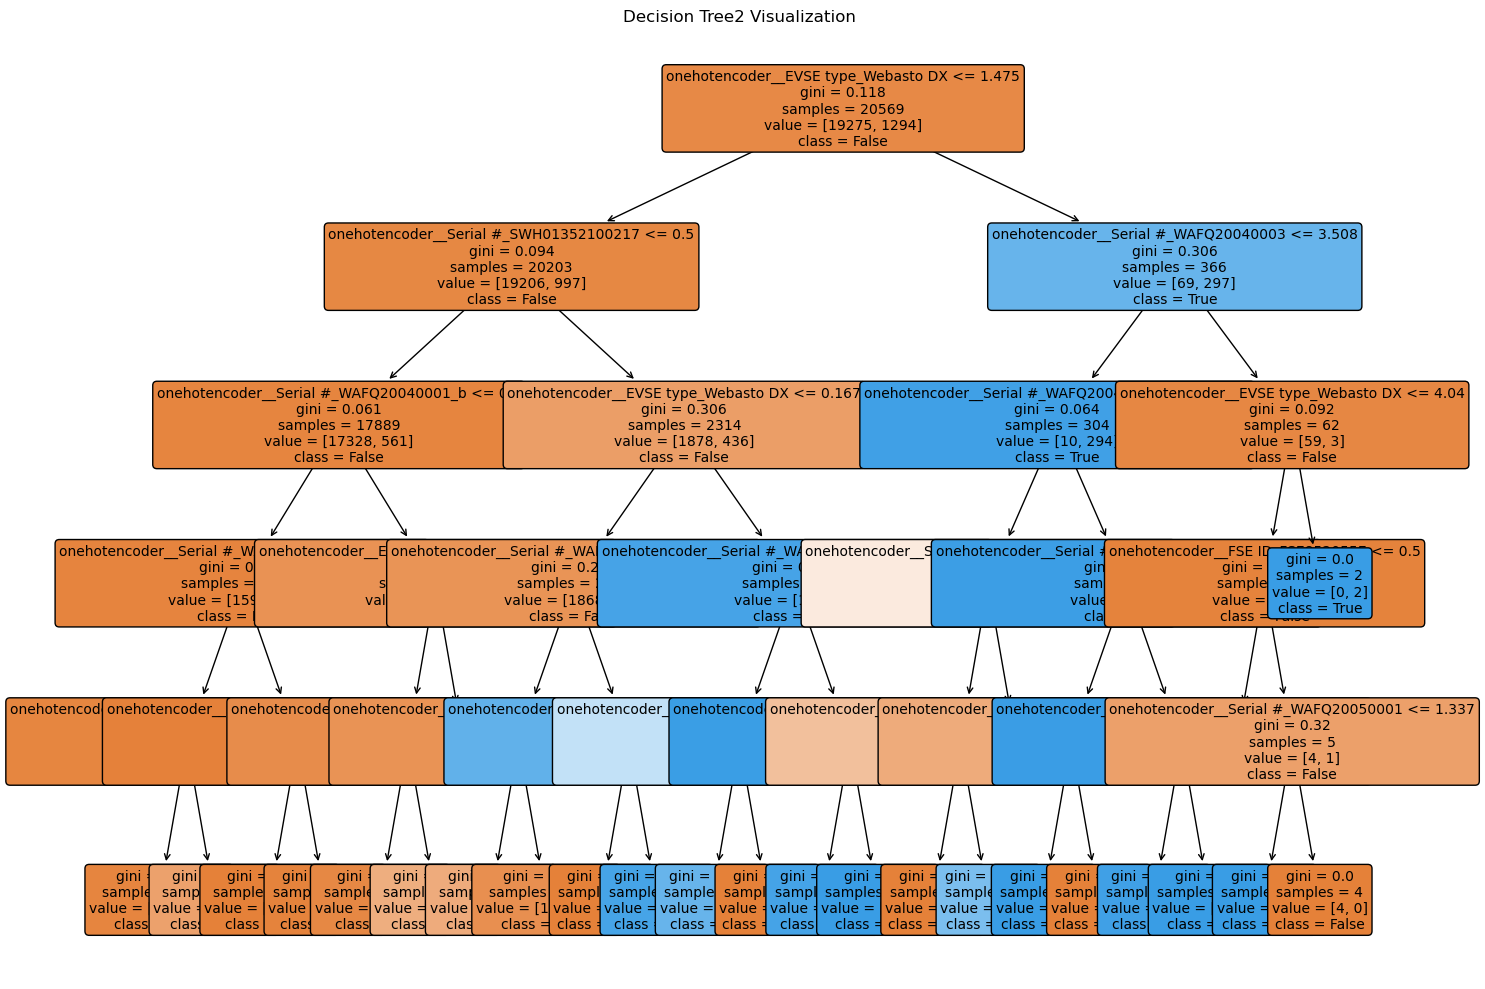

In [145]:
# Access the decision tree classifier from the pipeline
decision_tree2 = dtree_pipe2.named_steps['dtree']

# Create a figure with a suitable size
plt.figure(figsize=(15, 10))

# Plot the tree
plot_tree(decision_tree2, 
          filled=True, 
          feature_names=transformer.get_feature_names_out() if hasattr(transformer, 'get_feature_names_out') else None,
          class_names=[str(c) for c in decision_tree.classes_],
          rounded=True,
          fontsize=10,
          max_depth=5)  # Make sure this matches your tree's max_depth

plt.title("Decision Tree2 Visualization")
plt.tight_layout()
plt.show()